In [104]:
# Import data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
import geopandas as gpd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/judychen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Import Data

In [3]:
# Read in the listing data
df_listings = pd.read_csv('listings_summary202112.csv')
df_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,Other Cities,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,2016-05-15,0.02,1,226,0,NaN
1,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,Chas.,City of Los Angeles,Hollywood,34.09625,-118.34605,Private room,89,30,33,2021-11-01,0.69,3,327,5,NaN
2,2732,Zen Life at the Beach,3041,Yoga Priestess,Other Cities,Santa Monica,34.00440,-118.48095,Private room,167,7,21,2019-12-27,0.35,2,359,0,228269
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,Other Cities,Bellflower,33.87490,-118.11515,Entire home/apt,50,30,0,NaN,NaN,1,0,0,NaN
4,3021,Hollywood Hills Zen Modern style Apt/Guesthouse,3415,Nataraj,City of Los Angeles,Hollywood Hills West,34.11160,-118.38223,Entire home/apt,118,31,23,2018-10-31,0.23,4,308,0,NaN


In [4]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33329 entries, 0 to 33328
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33329 non-null  int64  
 1   name                            33327 non-null  object 
 2   host_id                         33329 non-null  int64  
 3   host_name                       33322 non-null  object 
 4   neighbourhood_group             33329 non-null  object 
 5   neighbourhood                   33329 non-null  object 
 6   latitude                        33329 non-null  float64
 7   longitude                       33329 non-null  float64
 8   room_type                       33329 non-null  object 
 9   price                           33329 non-null  int64  
 10  minimum_nights                  33329 non-null  int64  
 11  number_of_reviews               33329 non-null  int64  
 12  last_review                     

In [5]:
# Keep the valuable variables for listing summary data.
df_listings.drop(['host_name', 'neighbourhood_group', 'last_review', 'number_of_reviews_ltm', 'license'], axis=1, inplace=True)

In [6]:
# Read in the review data
df_reviews = pd.read_csv('reviews202112.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,2708,13994902,2014-06-09,10905424,Kuberan,i had a wonderful stay. Everything from start ...
3,2708,14606598,2014-06-23,2247288,Camilla,Charles is just amazing and he made my stay sp...
4,2708,39597339,2015-07-25,27974696,Fallon,Staying with Chas was an absolute pleasure. He...


In [8]:
# Keep the valuable varaibles for reviews.
df_reviews.drop(['id', 'reviewer_id', 'reviewer_name'], axis=1, inplace=True)

In [9]:
# Check missing values
df_reviews.isnull().sum()

listing_id       0
date             0
comments      1108
dtype: int64

In [10]:
# Remove if the review without review body.
df_reviews.dropna(subset=['comments'], inplace=True)
df_reviews.reset_index(inplace=True, drop=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142997 entries, 0 to 1142996
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1142997 non-null  int64 
 1   date        1142997 non-null  object
 2   comments    1142997 non-null  object
dtypes: int64(1), object(2)
memory usage: 26.2+ MB


In [11]:
# Combine both data and keep the valuable columns
df = pd.merge(df_listings, df_reviews, left_on='id', right_on='listing_id', how='inner')
df.head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_id,date,comments
0,109,Amazing bright elegant condo park front *UPGRA...,521,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,0.02,1,226,109,2011-08-15,The host canceled my reservation the day befor...
1,109,Amazing bright elegant condo park front *UPGRA...,521,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,0.02,1,226,109,2016-05-15,Me and two friends stayed for four and a half ...
2,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2014-06-09,i had a wonderful stay. Everything from start ...
3,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2014-06-23,Charles is just amazing and he made my stay sp...
4,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2015-07-25,Staying with Chas was an absolute pleasure. He...


# Data Cleaning and Exploration

### 2020 - 2021 Reviews Data

In [30]:
# Store the review data after COVID.
df_after = df[df['date'] > '2019-12-31']

Clean the data by removing non english reviews and autogenerated reviews

In [13]:
# Write a function for detecting the reviews' language with the langdetect in Python.
def language(word):
    try:
        return detect(word)
    except:
        return None

In [31]:
# Detect the comments' language for the data after COVID.
df_after['language'] = df_after['comments'].apply(lambda word: language(word))

<ipython-input-31-5d98cdf87cc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['language'] = df_after['comments'].apply(lambda word: language(word))


In [32]:
# Count the number of reviews in different languages.
df_after['language'].value_counts().head(10)

en       396391
es         2990
ro         2859
fr         2011
zh-cn      1045
af         1010
so          853
ko          656
de          614
tl          613
Name: language, dtype: int64

In [33]:
# Drop the non english reviews.
df_after = df_after.loc[df_after['language'] == 'en']

In [34]:
# Write a function for detecting the autogenerated post in the review.
def autogenerate(comment):
    if "This is an automated posting" in str(comment):
        return 0
    else:
        return 1

In [35]:
# Check if the reviews after COVID contain autogenerated post.
df_after['auto_comment'] = df_after['comments'].apply(lambda comment: autogenerate(comment))

In [36]:
# Example of autogenerated posts.
pd.options.display.max_colwidth = 100
auto = df_after.loc[df_after['auto_comment'] == 0]
auto.comments.head()

40247    The host canceled this reservation 11 days before arrival. This is an automated posting.
41776    The host canceled this reservation the day before arrival. This is an automated posting.
53360     The host canceled this reservation 3 days before arrival. This is an automated posting.
64825     The host canceled this reservation 2 days before arrival. This is an automated posting.
80689     The host canceled this reservation 4 days before arrival. This is an automated posting.
Name: comments, dtype: object

In [37]:
# Drop the autogenerated reviews and the unvaluable columns.
df_after = df_after.loc[df_after['auto_comment'] == 1]
df_after.drop(['language', 'auto_comment'], axis=1, inplace=True)
df_after.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395942 entries, 25 to 1142995
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              395942 non-null  int64  
 1   name                            395942 non-null  object 
 2   host_id                         395942 non-null  int64  
 3   neighbourhood                   395942 non-null  object 
 4   latitude                        395942 non-null  float64
 5   longitude                       395942 non-null  float64
 6   room_type                       395942 non-null  object 
 7   price                           395942 non-null  int64  
 8   minimum_nights                  395942 non-null  int64  
 9   number_of_reviews               395942 non-null  int64  
 10  reviews_per_month               395942 non-null  float64
 11  calculated_host_listings_count  395942 non-null  int64  
 12  availability_3

In [40]:
# Save file to avoid long runtime in the future
df_after.to_csv('reviews20_21.csv', index=False)

### 2018-2019 Reviews Data

In [54]:
# Store the review data between 2018 and 2019.
df_before = df[(df['date'] > '2017-12-31') & (df['date'] < '2020-01-01')]

Clean the data by removing non english reviews and autogenerated reviews

In [55]:
# Detect the comments' language for the data before COVID.
df_before['language'] = df_before['comments'].apply(lambda word: language(word))

<ipython-input-55-a165dfeabf00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['language'] = df_before['comments'].apply(lambda word: language(word))


In [56]:
# Count the number of reviews in different languages.
df_before['language'].value_counts().head(10)

en       422997
fr         6507
zh-cn      5395
es         4575
de         3503
ko         2327
ro         2027
it         1014
pt          942
ja          836
Name: language, dtype: int64

In [57]:
# Drop the non english reviews.
df_before = df_before.loc[df_before['language'] == 'en']

In [58]:
# Check if the reviews before COVID contain autogenerated post.
df_before['auto_comment'] = df_before['comments'].apply(lambda comment: autogenerate(comment))

In [59]:
# Drop the autogenerated reviews and the unvaluable columns.
df_before = df_before.loc[df_before['auto_comment'] == 1]
df_before.drop(['language', 'auto_comment'], axis=1, inplace=True)
df_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420788 entries, 8 to 1048979
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              420788 non-null  int64  
 1   name                            420788 non-null  object 
 2   host_id                         420788 non-null  int64  
 3   neighbourhood                   420788 non-null  object 
 4   latitude                        420788 non-null  float64
 5   longitude                       420788 non-null  float64
 6   room_type                       420788 non-null  object 
 7   price                           420788 non-null  int64  
 8   minimum_nights                  420788 non-null  int64  
 9   number_of_reviews               420788 non-null  int64  
 10  reviews_per_month               420788 non-null  float64
 11  calculated_host_listings_count  420788 non-null  int64  
 12  availability_36

In [60]:
# Save file to avoid long runtime in the future
df_before.to_csv('reviews18_19.csv', index=False)

# Sentimental Analysis Using VADER

In [41]:
# Using SentimentIntensityAnalyzer() to returns a dictionary of scores in negative, neutral, positive, and compound (normalized).
sid = SentimentIntensityAnalyzer()

### Data after COVID

In [42]:
# Apply function and get the scores for each reviews
df_after['scores'] = df_after['comments'].apply(lambda comments: sid.polarity_scores(comments))

In [43]:
# Carry out the compound score as a separate column.
df_after['compound'] = df_after['scores'].apply(lambda scores: scores['compound'])

In [44]:
# Write a function to assign 'positive' to a comments if compound score greater than 0, 'neutral' if compound score equals 0, otherwise 'negative'.
def sentiment_type(score):
    if score > 0:
        return 'positive'
    elif score == 0:
        return 'neutral'
    else:
        return 'negative'

In [45]:
# Apply function to get the sentiment type for each review.
df_after['sentiment_type'] = df_after['compound'].apply(sentiment_type)
df_after.head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_id,date,comments,scores,compound,sentiment_type
25,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2020-03-17,"Location is decent (near some great music stores, restaurants, and a lot of other things to do)....","{'neg': 0.051, 'neu': 0.872, 'pos': 0.077, 'compound': 0.881}",0.8810,positive
26,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2020-06-26,Charles was not only a gracious and accommodating host but he’s also full of insight and really ...,"{'neg': 0.02, 'neu': 0.658, 'pos': 0.321, 'compound': 0.987}",0.9870,positive
27,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2020-07-31,"This here is by far the best Airbnb I’ve stayed at, the apartment and building are beautiful and...","{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.9893}",0.9893,positive
28,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2020-10-06,Top notch spot to stay within walking distance to most everything in West Hollywood.,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'compound': 0.2023}",0.2023,positive
29,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2020-11-08,Great Find,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}",0.6249,positive


In [46]:
# Analyze the sentiment score
df_after.groupby('sentiment_type')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_type,,,,,,,,
negative,7927.0,-0.525112,0.289603,-0.9973,-0.7872,-0.5235,-0.28225,-0.0005
neutral,5318.0,0.000000,0.000000,0.0000,0.0000,0.0000,0.00000,0.0000
positive,382697.0,0.845930,0.160109,0.0011,0.7906,0.9071,0.95840,0.9998


#### Positive Comments

In [47]:
# Store positive comments from df_after as df_pos_after.
df_pos_after = df_after[df_after['sentiment_type'] == 'positive']

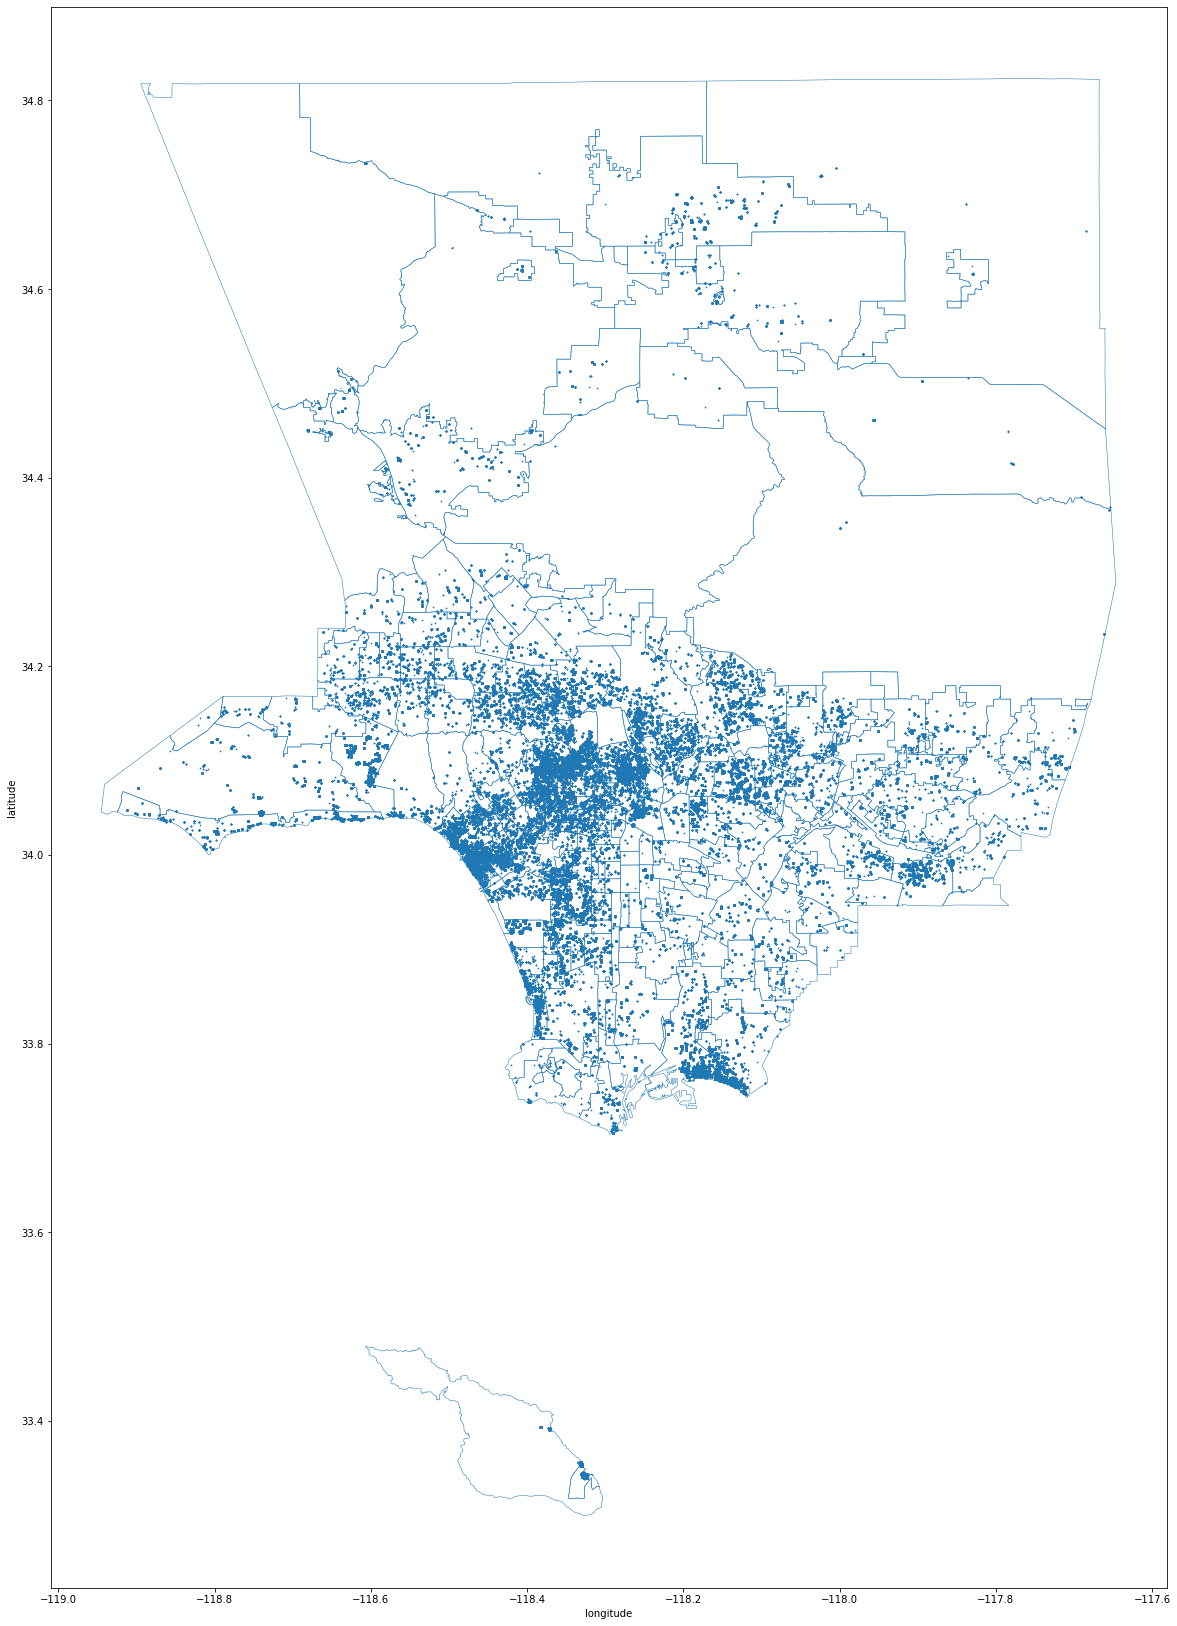

In [91]:
# Maps the distribution
la_map = gpd.read_file('neighbourhoods.geojson')
axs = la_map.boundary.plot(linewidth = 0.5)
df_pos_after.plot(x='longitude', y='latitude', kind='scatter', ax=axs, s = 0.5, figsize=(20,30))

plt.show()

In [48]:
# Find the top 10 neighbourhoods have the most positive reviews after COVID.
pos_neighbourhood_after = df_pos_after.groupby('neighbourhood')['compound'].describe().sort_values(['count'], ascending=False)
pos_neighbourhood_after.head(10)

,count,mean,std,min,25%,50%,75%,max
neighbourhood,,,,,,,,
Long Beach,30209.0,0.843097,0.161922,0.0015,0.7901,0.9041,0.9571,0.9997
Venice,17312.0,0.871189,0.142845,0.0089,0.8356,0.9259,0.9650,0.9992
Santa Monica,15475.0,0.848268,0.156157,0.0034,0.7960,0.9065,0.9570,0.9997
Inglewood,14194.0,0.821215,0.169124,0.0018,0.7506,0.8824,0.9458,0.9995
Topanga,11237.0,0.884204,0.136328,0.0387,0.8519,0.9368,0.9710,0.9992
Glendale,8897.0,0.841754,0.163683,0.0129,0.7897,0.9038,0.9570,0.9990
Pasadena,8422.0,0.853794,0.154317,0.0030,0.8016,0.9128,0.9612,0.9996
Hollywood,7357.0,0.832137,0.166829,0.0011,0.7684,0.8948,0.9527,0.9995
Hollywood Hills,7349.0,0.871663,0.143808,0.0106,0.8360,0.9272,0.9661,0.9995


In [49]:
# What room type has the highest average score.
pos_room_after = df_pos_after.groupby('room_type')['compound'].describe().sort_values(['mean', 'count'], ascending=False)
pos_room_after.head(10)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,298938.0,0.851477,0.156079,0.0015,0.8012,0.9111,0.959800,0.9998
Private room,80925.0,0.828417,0.170872,0.0011,0.7597,0.8932,0.953500,0.9994
Shared room,1664.0,0.778966,0.192291,0.0249,0.6588,0.8360,0.931900,0.9993
Hotel room,1170.0,0.735206,0.202586,0.0258,0.6249,0.7906,0.901625,0.9945


In [100]:
# Clean the comments by removing all non-letters and tranforming to lower case
def clean(comment):
    comment = re.sub("[^a-zA-Z ]", "", str(comment))  # Replace all non-letters with spaces
    comment = comment.lower()                         # Tranform to lower case    
    return comment.strip()

In [101]:
# Clean the positive reviews.
df_pos_after.comments = df_pos_after.comments.apply(clean)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


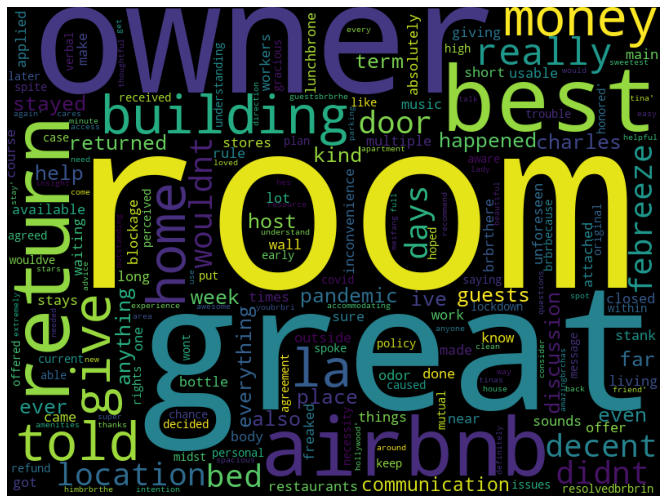

In [109]:
# Generate wordcloud
pos_after_wc = WordCloud(max_words=200, width=800, height=600, stopwords=stopwords.words('english')).generate(str(df_pos_after.comments.values))

plt.figure(figsize=[12,9])
plt.axis('off')
plt.imshow(pos_after_wc)

#### Negative Reviews

In [50]:
# Store negative comments from df_after as df_neg_after.
df_neg_after = df_after[df_after['sentiment_type'] == 'negative']

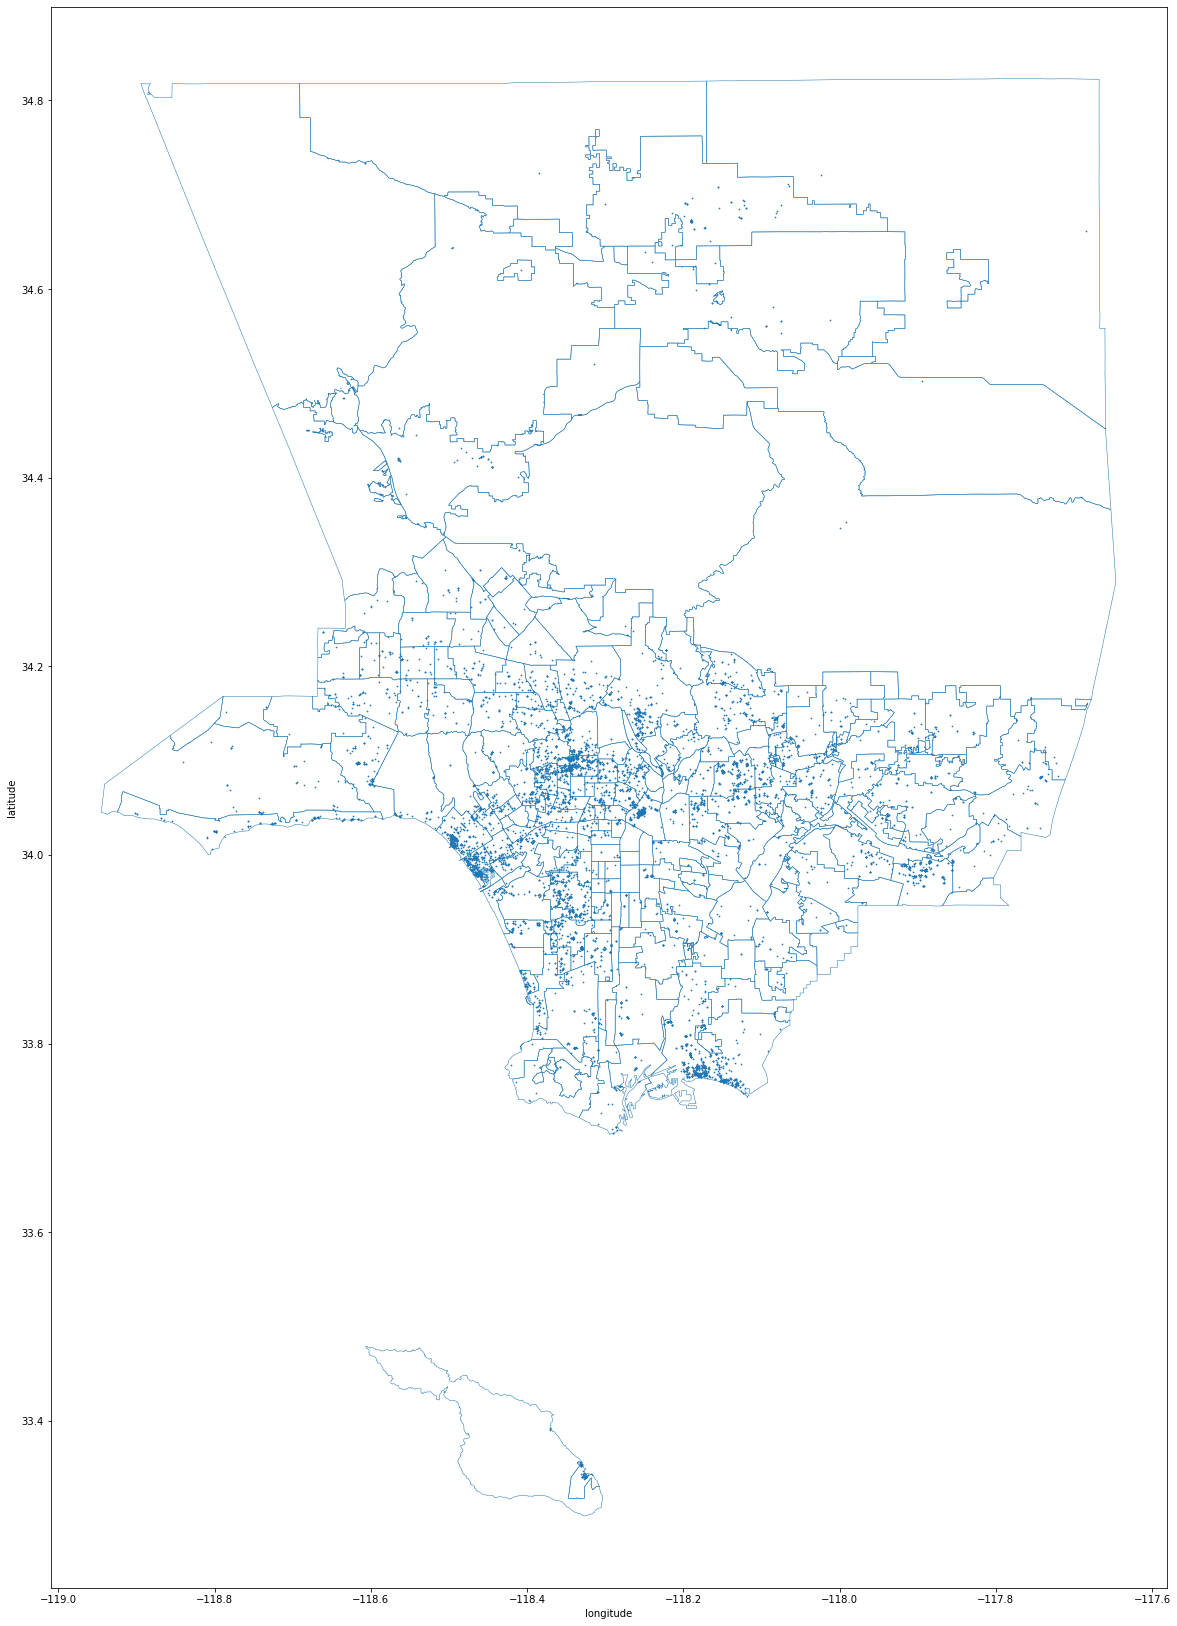

In [92]:
# Maps the distribution
la_map = gpd.read_file('neighbourhoods.geojson')
axs = la_map.boundary.plot(linewidth = 0.5)
df_neg_after.plot(x='longitude', y='latitude', kind='scatter', ax=axs, s = 0.5, figsize=(20,30))

plt.show()

In [51]:
# Find the top 10 neighbourhoods that people complain the most after COVID.
neg_neighbourhood_after = df_neg_after.groupby('neighbourhood')['compound'].describe().sort_values(['count'], ascending=False)
neg_neighbourhood_after.head(10)

,count,mean,std,min,25%,50%,75%,max
neighbourhood,,,,,,,,
Long Beach,751.0,-0.519738,0.291407,-0.9941,-0.778600,-0.51750,-0.273200,-0.0036
Santa Monica,377.0,-0.535880,0.281840,-0.9954,-0.786200,-0.52670,-0.296000,-0.0067
Downtown,358.0,-0.544040,0.286195,-0.9942,-0.802000,-0.54840,-0.296000,-0.0018
Inglewood,304.0,-0.484714,0.274879,-0.9956,-0.682800,-0.46255,-0.275500,-0.0038
Venice,276.0,-0.504716,0.311351,-0.9948,-0.807900,-0.49130,-0.226300,-0.0088
Hollywood,246.0,-0.544435,0.301775,-0.9958,-0.856975,-0.54475,-0.278250,-0.0018
Glendale,236.0,-0.543266,0.307246,-0.9971,-0.830125,-0.54230,-0.296000,-0.0041
Rowland Heights,199.0,-0.521319,0.274015,-0.9866,-0.751500,-0.52670,-0.296000,-0.0150
Alhambra,194.0,-0.489553,0.281079,-0.9882,-0.719800,-0.44040,-0.273775,-0.0164


In [53]:
# Negative reviews distribution for each room type.
neg_room_after = df_neg_after.groupby('room_type')['compound'].describe().sort_values(['mean', 'count'], ascending=True)
neg_room_after.head(10)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,5826.0,-0.532021,0.292691,-0.9966,-0.798475,-0.53220,-0.287475,-0.0005
Hotel room,85.0,-0.508076,0.283708,-0.9590,-0.764100,-0.55260,-0.250000,-0.0352
Private room,1928.0,-0.506450,0.279568,-0.9973,-0.750300,-0.49390,-0.275500,-0.0005
Shared room,88.0,-0.493041,0.289702,-0.9864,-0.777925,-0.43095,-0.273200,-0.0516


In [110]:
# Clean the positive reviews.
df_neg_after.comments = df_neg_after.comments.apply(clean)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


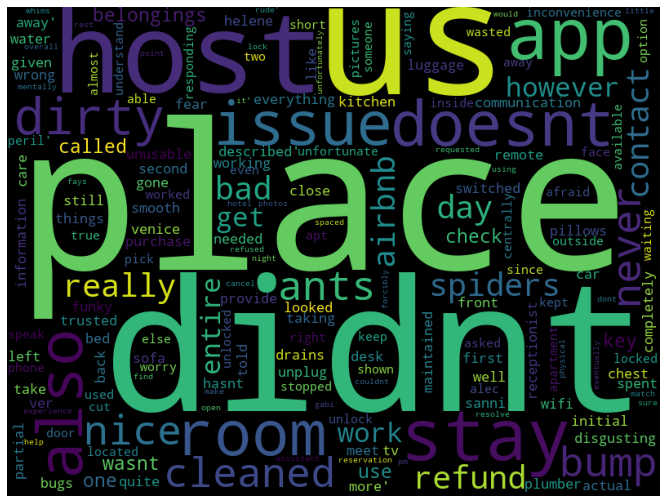

In [112]:
# Generate wordcloud
neg_after_wc = WordCloud(max_words=200, width=800, height=600, stopwords=stopwords.words('english')).generate(str(df_neg_after.comments.values))

plt.figure(figsize=[12,9])
plt.axis('off')
plt.imshow(neg_after_wc)

### Data before COVID

In [61]:
# Apply function and get the scores for each reviews
df_before['scores'] = df_before['comments'].apply(lambda comments: sid.polarity_scores(comments))

In [62]:
# Carry out the compound score as a separate column.
df_before['compound'] = df_before['scores'].apply(lambda scores: scores['compound'])

In [63]:
# Get the sentiment type for each review.
df_before['sentiment_type'] = df_before['compound'].apply(sentiment_type)
df_before.head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_id,date,comments,scores,compound,sentiment_type
8,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2018-01-05,"Chas house feels like home, it is clean, it has bright energy, it’s mystical, it’s fabulous. Cha...","{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.9631}",0.9631,positive
9,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2018-01-13,1. Clean 2. Host is very friendly 3. Reasonable price 4. Good location 5.Very comfortable to use...,"{'neg': 0.0, 'neu': 0.593, 'pos': 0.407, 'compound': 0.9719}",0.9719,positive
10,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2018-07-01,Wow; Charles was a delight to meet a very warm and friendly man whom made me feel comfortable an...,"{'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'compound': 0.9863}",0.9863,positive
11,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2018-07-15,Chas. has a great space ! Loved how clean everything was and how available he was to help out wi...,"{'neg': 0.0, 'neu': 0.534, 'pos': 0.466, 'compound': 0.9323}",0.9323,positive
12,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Firplc,3008,Hollywood,34.09625,-118.34605,Private room,89,30,33,0.69,3,327,2708,2018-07-26,"Chas is a great host, very friendly and welcoming (and informative!). He keeps his place spotle...","{'neg': 0.0, 'neu': 0.688, 'pos': 0.312, 'compound': 0.9882}",0.9882,positive


In [64]:
# Analyze the sentiment score
df_before.groupby('sentiment_type')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_type,,,,,,,,
negative,5807.0,-0.48088,0.284443,-0.9972,-0.7173,-0.4585,-0.2481,-0.0005
neutral,5036.0,0.00000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
positive,409945.0,0.85518,0.154842,0.0005,0.8074,0.9144,0.9611,0.9997


#### Positive Comments

In [65]:
# Store positive comments from df_before as df_pos_before.
df_pos_before = df_before[df_before['sentiment_type'] == 'positive']

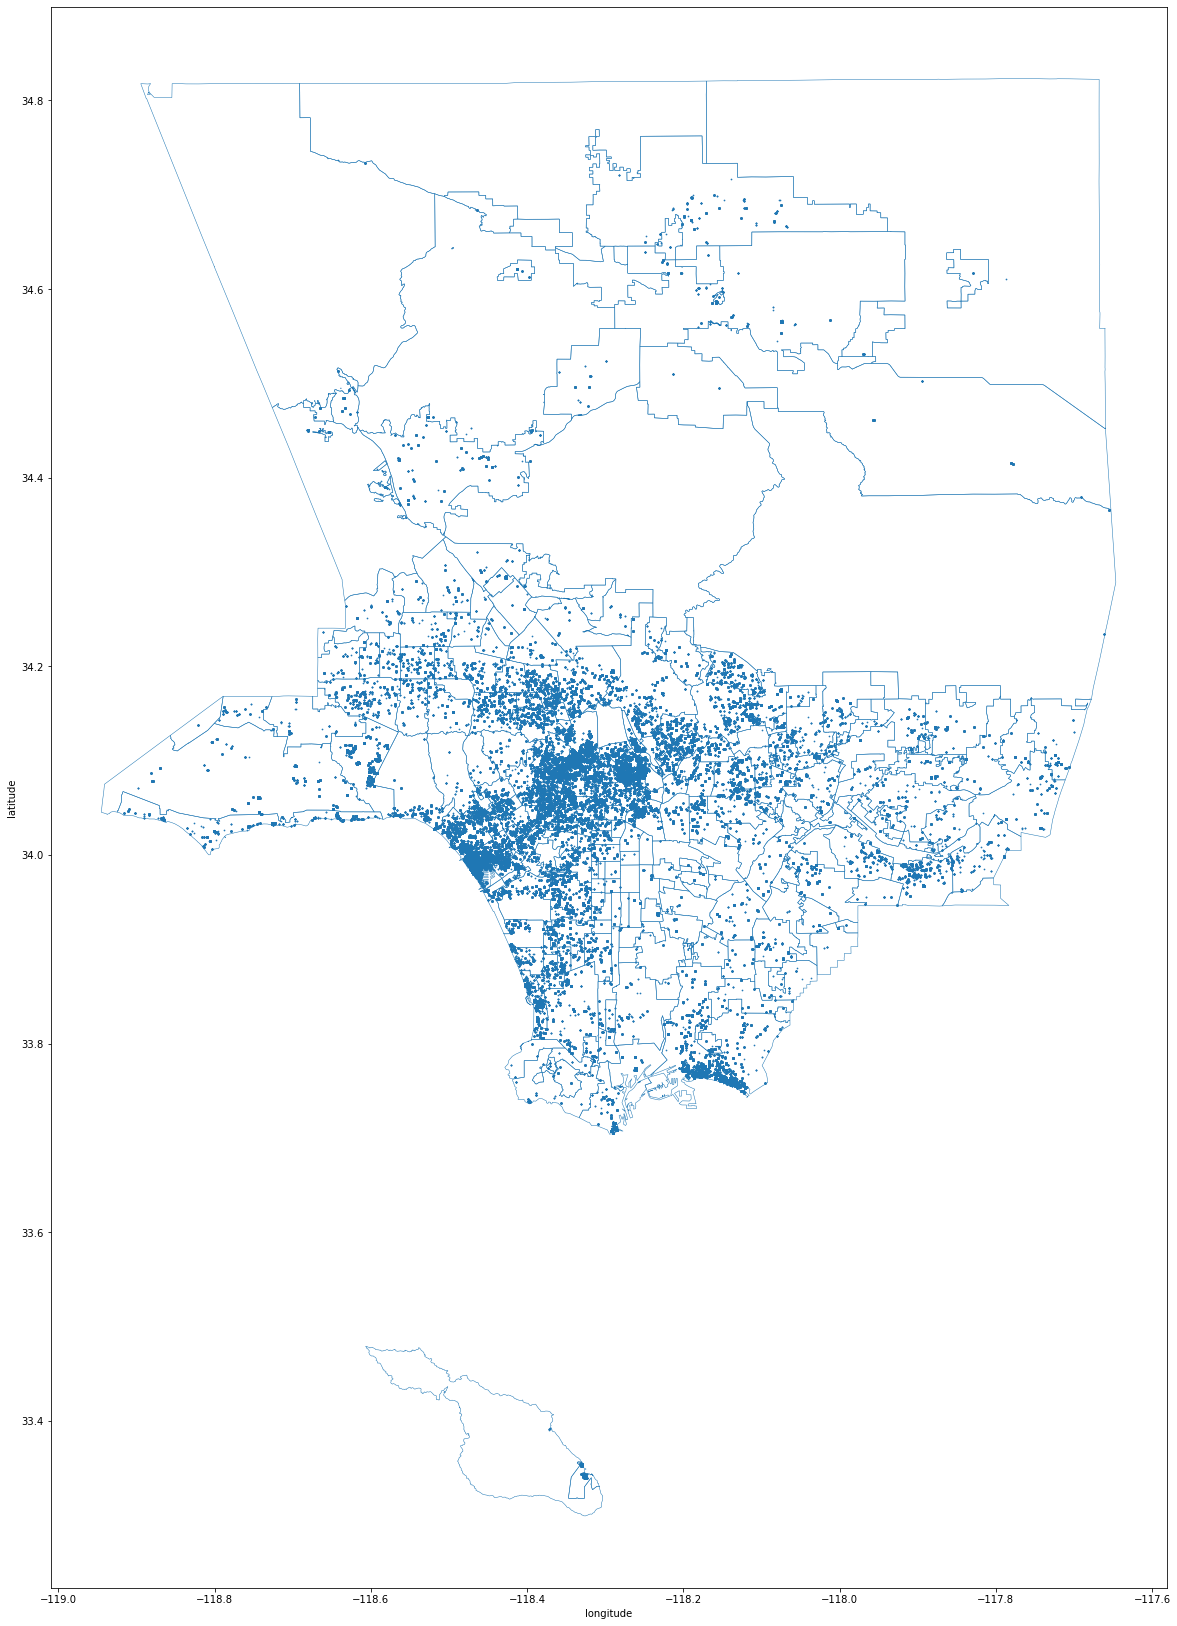

In [93]:
# Maps the distribution
la_map = gpd.read_file('neighbourhoods.geojson')
axs = la_map.boundary.plot(linewidth = 0.5)
df_pos_before.plot(x='longitude', y='latitude', kind='scatter', ax=axs, s = 0.5, figsize=(20,30))

plt.show()

In [66]:
# Find the top 10 neighbourhoods have the most positive reviews before COVID.
pos_neighbourhood_before = df_pos_before.groupby('neighbourhood')['compound'].describe().sort_values(['count'], ascending=False)
pos_neighbourhood_before.head(10)

,count,mean,std,min,25%,50%,75%,max
neighbourhood,,,,,,,,
Venice,34121.0,0.869230,0.145051,0.0073,0.8319,0.9239,0.965000,0.9997
Long Beach,23885.0,0.849578,0.157388,0.0009,0.8011,0.9092,0.958300,0.9989
Hollywood,16593.0,0.842684,0.159709,0.0129,0.7906,0.9022,0.954700,0.9992
Santa Monica,12871.0,0.868974,0.145181,0.0018,0.8316,0.9245,0.964200,0.9993
Silver Lake,11687.0,0.889225,0.128778,0.0087,0.8619,0.9378,0.969200,0.9994
Hollywood Hills,10384.0,0.873935,0.143851,0.0202,0.8399,0.9284,0.967400,0.9990
Downtown,8337.0,0.834228,0.166898,0.0018,0.7783,0.8975,0.953100,0.9986
Pasadena,8207.0,0.854009,0.152396,0.0245,0.8016,0.9118,0.959900,0.9984
Inglewood,7941.0,0.825742,0.169975,0.0018,0.7620,0.8885,0.948500,0.9980


In [67]:
# What room type has the highest average score.
pos_room_before = df_pos_before.groupby('room_type')['compound'].describe().sort_values(['mean', 'count'], ascending=False)
pos_room_before.head(10)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,294910.0,0.858815,0.152062,0.0005,0.8126,0.9167,0.9618,0.9997
Private room,111095.0,0.847780,0.160015,0.0014,0.7959,0.9097,0.9594,0.9997
Hotel room,1825.0,0.792297,0.185051,0.0516,0.6945,0.8519,0.9334,0.9978
Shared room,2115.0,0.791278,0.190659,0.0176,0.6808,0.8588,0.9393,0.9979


In [113]:
# Clean the positive reviews.
df_pos_before.comments = df_pos_before.comments.apply(clean)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


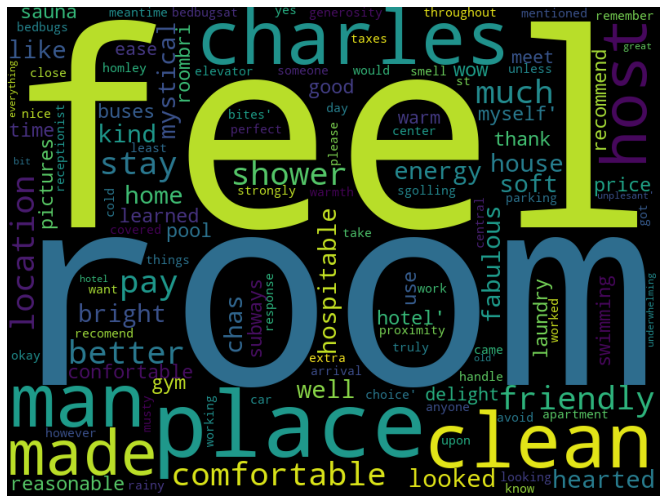

In [114]:
# Generate wordcloud
pos_before_wc = WordCloud(max_words=200, width=800, height=600, stopwords=stopwords.words('english')).generate(str(df_pos_before.comments.values))

plt.figure(figsize=[12,9])
plt.axis('off')
plt.imshow(pos_before_wc)

#### Negative Comments

In [68]:
# Store negative comments from df_after as df_neg_after.
df_neg_before = df_before[df_before['sentiment_type'] == 'negative']

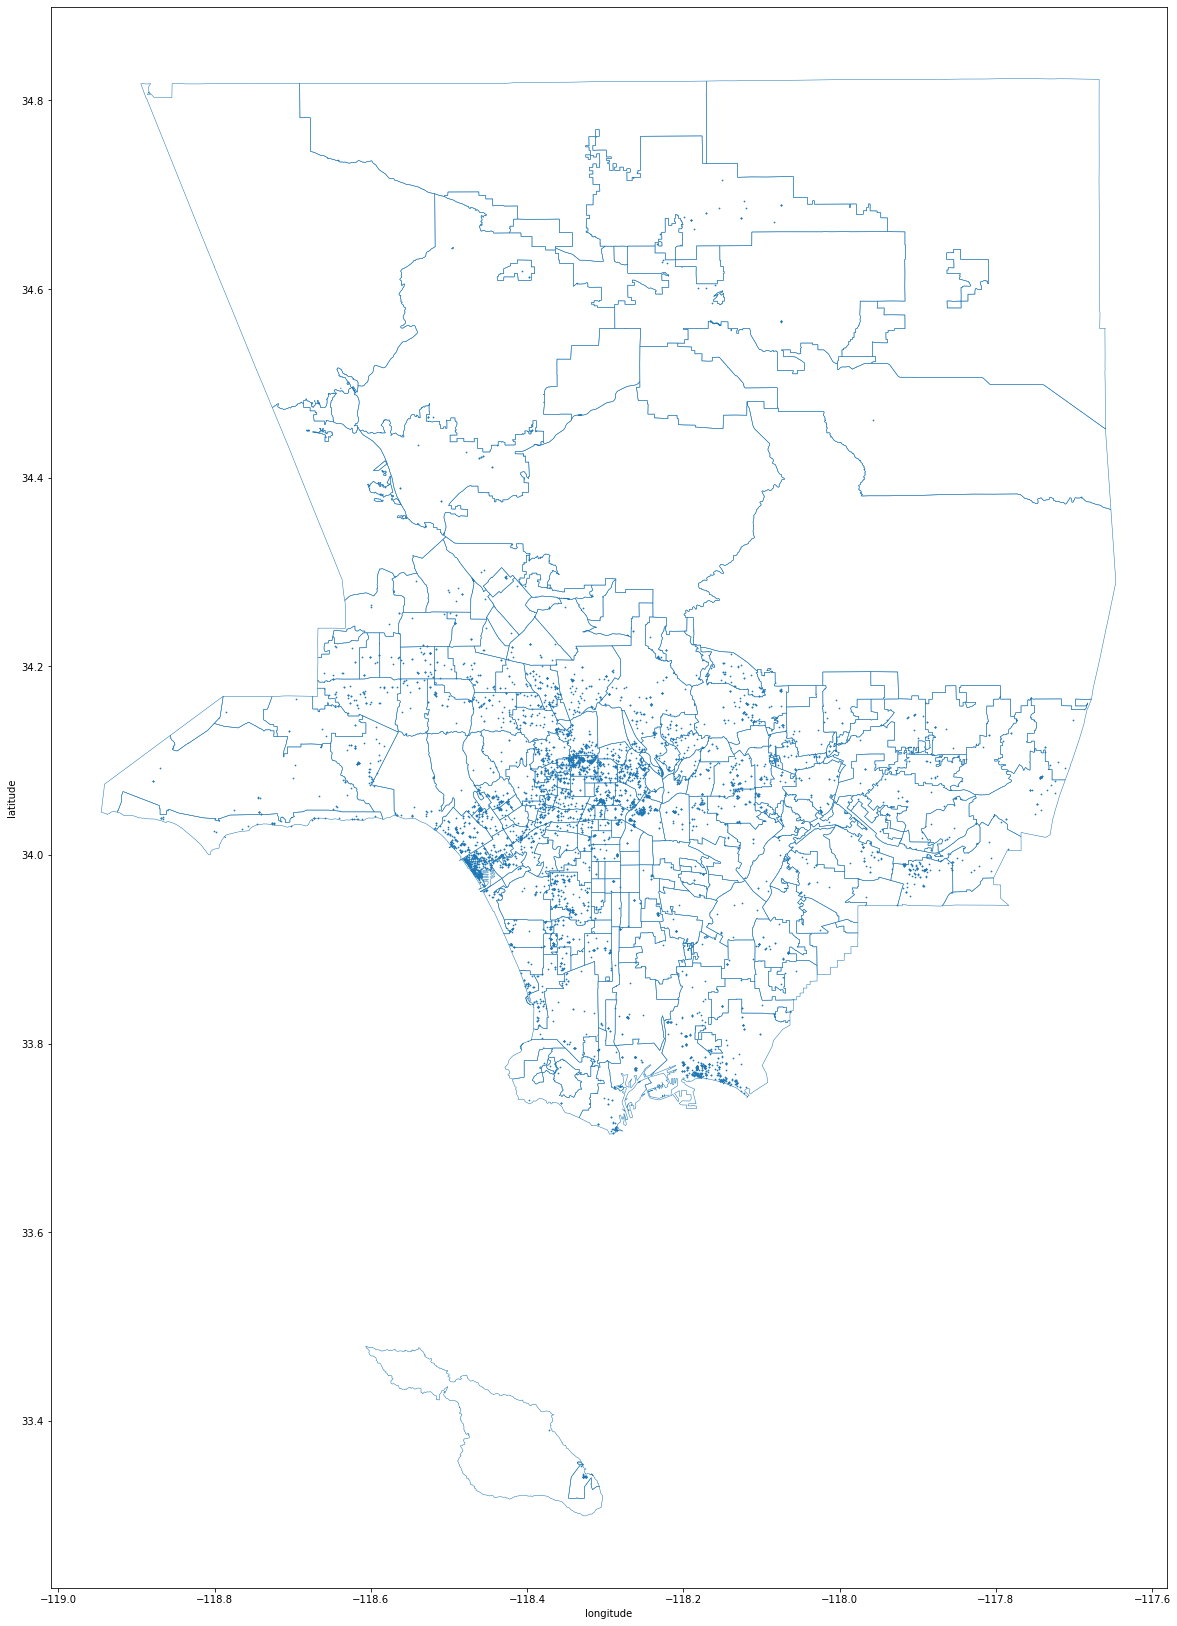

In [94]:
# Maps the distribution
la_map = gpd.read_file('neighbourhoods.geojson')
axs = la_map.boundary.plot(linewidth = 0.5)
df_neg_before.plot(x='longitude', y='latitude', kind='scatter', ax=axs, s = 0.5, figsize=(20,30))

plt.show()

In [69]:
# Find the top 10 neighbourhoods that people complain the most after COVID.
neg_neighbourhood_before = df_neg_before.groupby('neighbourhood')['compound'].describe().sort_values(['count'], ascending=False)
neg_neighbourhood_before.head(10)

,count,mean,std,min,25%,50%,75%,max
neighbourhood,,,,,,,,
Long Beach,440.0,-0.478632,0.281657,-0.9941,-0.706925,-0.45610,-0.241250,-0.0005
Venice,403.0,-0.471948,0.299663,-0.9921,-0.735000,-0.44170,-0.195350,-0.0009
Hollywood,308.0,-0.498406,0.297282,-0.9904,-0.770225,-0.49390,-0.250000,-0.0057
Downtown,191.0,-0.479367,0.281020,-0.9891,-0.700850,-0.47670,-0.254200,-0.0129
Santa Monica,164.0,-0.504500,0.286955,-0.9874,-0.786300,-0.47395,-0.270525,-0.0129
Inglewood,160.0,-0.473769,0.267383,-0.9874,-0.651475,-0.47465,-0.252625,-0.0018
Koreatown,154.0,-0.465041,0.289463,-0.9936,-0.693375,-0.44945,-0.200800,-0.0152
Hollywood Hills,117.0,-0.459804,0.276444,-0.9934,-0.678100,-0.44040,-0.250000,-0.0018
Rowland Heights,93.0,-0.502911,0.267898,-0.9453,-0.713800,-0.49390,-0.296000,-0.0118


In [70]:
# Negative reviews distribution for each room type.
neg_room_before = df_neg_before.groupby('room_type')['compound'].describe().sort_values(['mean', 'count'], ascending=True)
neg_room_before.head(10)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Shared room,75.0,-0.543477,0.293184,-0.9796,-0.78040,-0.5994,-0.29635,-0.0064
Hotel room,75.0,-0.541579,0.271977,-0.9776,-0.79175,-0.5187,-0.32260,-0.0191
Entire home/apt,4119.0,-0.485548,0.287738,-0.9972,-0.72690,-0.4639,-0.25000,-0.0005
Private room,1538.0,-0.462366,0.274469,-0.9961,-0.67980,-0.4320,-0.22630,-0.0011
